In [43]:
%matplotlib inline
import numpy as np
import time
import matplotlib as mpl
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
mpl.rcParams['lines.markersize'] = 3
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.init as init
from torch.optim.lr_scheduler import ExponentialLR

import nn_models

torch.set_default_dtype(torch.float64)
torch.manual_seed(24)

MASS = 1.0
HBAR = 1.0
AUTOEV = 27.2114
AUTONM = 0.05291772108
NQGRID = 2048

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available.


In [50]:
def plotBandStruct(bandStruct_array, marker_array, label_array): 
    fig, axs = plt.subplots(1,2, figsize=(7,3))
    for bandStructIndex in range(len(bandStruct_array)): 
        numBands = len(bandStruct_array[bandStructIndex][0])
        numKpts = len(bandStruct_array[bandStructIndex])
        for i in range(numBands): 
            if i==0: 
                axs[0].plot(np.arange(numKpts), bandStruct_array[bandStructIndex][:, i].detach().numpy(), marker_array[bandStructIndex], label=label_array[bandStructIndex])
                axs[1].plot(np.arange(numKpts), bandStruct_array[bandStructIndex][:, i].detach().numpy(), marker_array[bandStructIndex], label=label_array[bandStructIndex])
            else: 
                axs[0].plot(np.arange(numKpts), bandStruct_array[bandStructIndex][:, i].detach().numpy(), marker_array[bandStructIndex])
                axs[1].plot(np.arange(numKpts), bandStruct_array[bandStructIndex][:, i].detach().numpy(), marker_array[bandStructIndex])
    axs[0].legend(frameon=False)
    axs[1].set(ylim=(-8, -2))
    axs[0].get_xaxis().set_ticks([0, 20, 40, 45, 60])
    axs[0].get_xaxis().set_ticklabels(["L", r"$\Gamma$", "X", "K", r"$\Gamma$"])
    axs[1].get_xaxis().set_ticks([0, 20, 40, 45, 60])
    axs[1].get_xaxis().set_ticklabels(["L", r"$\Gamma$", "X", "K", r"$\Gamma$"])
    fig.tight_layout()
    plt.show()
    return

def pot_func(x, params): 
    pot = (params[0]*(x*x - params[1]) / (params[2] * torch.exp(params[3]*x*x) - 1.0))
    return pot
    
def plotPP(q_array, vq_Cd_array, vq_Se_array, label_array, lineshape_array, boolPlotDiff): 
    if boolPlotDiff: 
        fig, axs = plt.subplots(1,2, figsize=(7,3))
        for i in range(len(q_array)): 
            q = q_array[i].view(-1).detach().numpy()
            vq_Cd = vq_Cd_array[i].view(-1).detach().numpy()
            vq_Se = vq_Se_array[i].view(-1).detach().numpy()
            axs[0].plot(q, vq_Cd, lineshape_array[i], label="Cd "+label_array[i])
            axs[0].plot(q, vq_Se, lineshape_array[i], label="Se "+label_array[i])
        axs[0].set(xlabel=r"$q$", ylabel=r"$v(q)$")
        axs[0].legend(frameon=False)
        
        axs[1].plot(q_array[0].view(-1).detach().numpy(), vq_Cd_array[1].view(-1).detach().numpy() - vq_Cd_array[0].view(-1).detach().numpy(), lineshape_array[0], label="Cd")
        axs[1].plot(q_array[0].view(-1).detach().numpy(), vq_Se_array[1].view(-1).detach().numpy() - vq_Se_array[0].view(-1).detach().numpy(), lineshape_array[0], label="Se")
        axs[1].set(xlabel=r"$q$", ylabel=r"$v_{NN}(q) - v_{func}(q)$")
        axs[1].legend(frameon=False)
    else:
        fig, axs = plt.subplots(1,1, figsize=(4,4))
        for i in range(len(q_array)): 
            q = q_array[i].view(-1).detach().numpy()
            vq_Cd = vq_Cd_array[i].view(-1).detach().numpy()
            vq_Se = vq_Se_array[i].view(-1).detach().numpy()
            axs.plot(q, vq_Cd, lineshape_array[i], label="Cd "+label_array[i])
            axs.plot(q, vq_Se, lineshape_array[i], label="Se "+label_array[i])
        axs.set(xlabel=r"$q$", ylabel=r"$v(q)$")
        axs.legend(frameon=False)
    fig.tight_layout()
    plt.show()
    return

def plot_training_validation_cost(training_cost, validation_cost, ylogBoolean): 
    if len(training_cost) != len(validation_cost): 
        return
    else:
        epochs = range(1, len(training_cost) + 1)
    
    # Plot training and validation costs
    plt.figure(figsize=(8, 6))
    
    plt.plot(epochs, training_cost, "b-", label='Training Cost')
    plt.plot(epochs, validation_cost, "r:", label='Validation Cost')
    
    if ylogBoolean:
        plt.yscale('log')
    else: 
        plt.yscale('linear')
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.legend()
    plt.title('Training and Validation Costs')
    plt.grid(True)
    plt.show()
    return

In [45]:
# Semiconductor system details
nSystem = 1

# read input
maxKE = 10
nBands = 16

# read multiple input

# read system
scale = 11.4485278
unitCellVector1 = torch.tensor([0.0, 0.5, 0.5]) * scale
unitCellVector2 = torch.tensor([0.5, 0.0, 0.5]) * scale
unitCellVector3 = torch.tensor([0.5, 0.5, 0.0]) * scale
unitCellVectors = torch.cat((unitCellVector1.unsqueeze(0), unitCellVector2.unsqueeze(0), unitCellVector3.unsqueeze(0)), dim=0)
cellVolume = torch.dot(unitCellVector1, torch.cross(unitCellVector2, unitCellVector3))
nAtoms = 2
atomTypes = np.array(["Cd", "Se"])
atomPos = torch.tensor([[0.125, 0.125, 0.125],
                        [-0.125, -0.125, -0.125]])
atomPos = atomPos @ unitCellVectors

# calculate reciprocal space vectors
prefactor = 2 * np.pi / cellVolume
gVector1 = prefactor * torch.cross(unitCellVectors[1], unitCellVectors[2])
gVector2 = prefactor * torch.cross(unitCellVectors[2], unitCellVectors[0])
gVector3 = prefactor * torch.cross(unitCellVectors[0], unitCellVectors[1])
gVectors = torch.cat((gVector1.unsqueeze(0), gVector2.unsqueeze(0), gVector3.unsqueeze(0)), dim=0)

# read kPoints
kpt_zbCdSe = torch.tensor(np.loadtxt("ZB_kpoints.par"))
kpt_zbCdSe = kpt_zbCdSe @ gVectors
nkpt = kpt_zbCdSe.shape[0]

# read band strcture
Eref_zbCdSe = torch.tensor(np.loadtxt("bandStruct_zbCdSe.par")[:, 1:])

In [46]:
# Current Cd, Se, S pp's in Zunger's form
CdParams = torch.tensor([-31.4518, 1.3890, -0.0502, 1.6603, 0.0586])
SeParams = torch.tensor([8.4921, 4.3513, 1.3600, 0.3227, 0.1746])
SParams = torch.tensor([7.6697, 4.5192, 1.3456, 0.3035, 0.2087])
PP_order = np.array(["Cd", "Se", "S"])
totalParams = torch.cat((CdParams.unsqueeze(0), SeParams.unsqueeze(0), SParams.unsqueeze(0)), dim=0)

class init_Zunger_data(Dataset):
    def __init__(self,train=True):
        if train==True:
            self.q = (torch.rand(4000, 1) * 10.0).view(-1,1)
            self.q[0:10, 0] = 0.0
            self.vq_Cd = pot_func(self.q, CdParams)
            self.vq_Se = pot_func(self.q, SeParams)
            mask = (self.q > 0) & (self.q < 1)
            self.w = torch.where(mask, torch.tensor(10.0), torch.tensor(1.0))
        elif train==False:
            self.q = torch.linspace(0.0, 10.0, NQGRID).view(-1,1)
            self.vq_Cd = pot_func(self.q, CdParams)
            self.vq_Se = pot_func(self.q, SeParams)
            self.w = torch.ones_like(self.q)
        self.len = self.q.shape[0]
    def __getitem__(self,index):
        return self.q[index],self.vq_Cd[index],self.vq_Se[index],self.w[index]
    def __len__(self):
        return self.len
    
train_dataset = init_Zunger_data(True)
val_dataset = init_Zunger_data(False)

In [47]:
def basis(maxKE, scale, unitCellVectors, gVectors, cellVolume): 
    minGMag = min(torch.norm(gVectors[0]), torch.norm(gVectors[1]), torch.norm(gVectors[2]))
    numMaxBasisVectors = int(np.sqrt(2*maxKE) / minGMag)
    # print(numMaxBasisVectors)

    k = torch.arange(-numMaxBasisVectors, numMaxBasisVectors+1, dtype=torch.float64).repeat((2*numMaxBasisVectors+1)**2)
    j = torch.arange(-numMaxBasisVectors, numMaxBasisVectors+1, dtype=torch.float64).repeat_interleave((2*numMaxBasisVectors+1)).repeat((2*numMaxBasisVectors+1))
    i = torch.arange(-numMaxBasisVectors, numMaxBasisVectors+1, dtype=torch.float64).repeat_interleave((2*numMaxBasisVectors+1)**2)
    allGrid = torch.vstack((i, j, k)).T
    transform = gVectors.T
    allBasisSet = allGrid @ transform
    # print(allBasisSet.shape[0])
    # print(allBasisSet)

    row_norms = torch.norm(allBasisSet, dim=1)
    condition = (HBAR*0.5*row_norms**2 / MASS < maxKE)
    indices = torch.where(condition)[0]
    basisSet = allBasisSet[indices]
    # print(basisSet.shape[0])
    # print(basisSet)
    
    sorting_indices = torch.argsort(basisSet[:, 2], stable=True)
    basisSet = basisSet[sorting_indices]
    sorting_indices = torch.argsort(basisSet[:, 1], stable=True)
    basisSet = basisSet[sorting_indices]
    sorting_indices = torch.argsort(basisSet[:, 0], stable=True)
    basisSet = basisSet[sorting_indices]
    row_norms = torch.norm(basisSet, dim=1)
    sorting_indices = torch.argsort(row_norms[:], stable=True)
    sorted_basisSet = basisSet[sorting_indices]
    
    return sorted_basisSet

# construct hamiltonian at a certain k-point (kVector). Quicker through vectorization. 
# TODO: add a variable to this function: model
def calcHamiltonianMatrix(NN_boolean, basisStates, kVector, nAtoms, cellVolume):
    n = basisStates.shape[0]
    HMatrix = torch.zeros((n, n), dtype=torch.complex128)

    # Kinetic energy
    for i in range(n): 
        HMatrix[i,i] += HBAR**2 / (2*MASS) * (torch.norm(basisStates[i] + kVector))**2
        
    # Local potential
    gDiff = torch.stack([basisStates] * (basisStates.shape[0]), dim=1) - basisStates.repeat(basisStates.shape[0], 1, 1)
    
    for k in range(nAtoms): 
        gDiffDotTau = torch.sum(gDiff * atomPos[k], axis=2)
        structFact = 1/cellVolume * (torch.cos(gDiffDotTau) + 1j*torch.sin(gDiffDotTau))

        thisAtomIndex = np.where(atomTypes[k]==PP_order)[0]
        if len(thisAtomIndex)!=1: 
            raise ValueError("Type of atoms in PP. ")
        thisAtomIndex = thisAtomIndex[0]
        
        if NN_boolean: 
            atomFF = PPmodel(torch.norm(gDiff, dim=2).view(-1, 1))
            atomFF = atomFF[:, thisAtomIndex].view(n, n)
        else: 
            atomFF = pot_func(torch.norm(gDiff, dim=2), totalParams[thisAtomIndex])
        
        HMatrix += atomFF * structFact
    return HMatrix

def calcBandStruct(NN_boolean, basisStates, nkpt, kpts_coord, nAtoms, cellVolume, nBands): 
    bandStruct = torch.zeros((nkpt, nBands))
    for kpt_index in range(nkpt): 
        HamiltonianMatrixAtKpt = calcHamiltonianMatrix(NN_boolean, basisStates, kpts_coord[kpt_index], nAtoms, cellVolume)

        # diagonalize the hamiltonian
        energies = torch.linalg.eigvalsh(HamiltonianMatrixAtKpt)
        
        energiesEV = energies * AUTOEV
        # 2-fold degeneracy due to spin
        final_energies = energiesEV.repeat_interleave(2)[:nBands]
    
        bandStruct[kpt_index] = final_energies

    return bandStruct

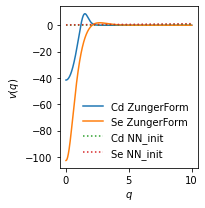

Epoch [500/1000], Validation Loss: 0.3681


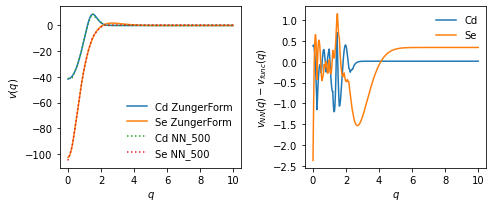

Epoch [1000/1000], Validation Loss: 0.3242


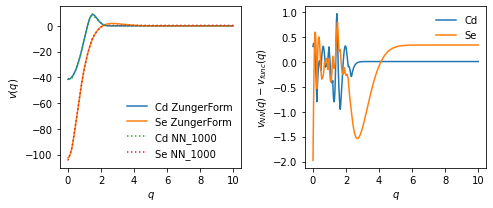

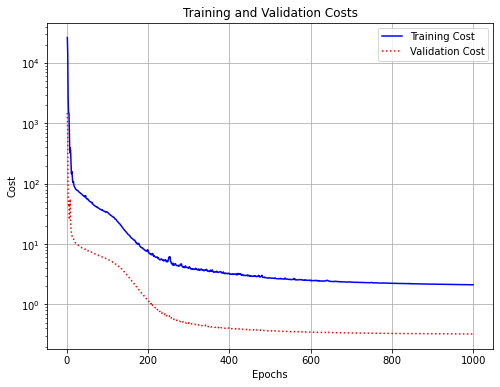

GPU training: elapsed time: 55.98336863517761 seconds


In [48]:
# Create Net model class
# PPmodel = nn_models.Net_relu_xavier_BN_dropout_decay([1, 20, 20, 20, 2])
PPmodel = nn_models.Net_relu_xavier([1, 20, 20, 20, 2])

# Validating on the initialized NN model
# print("list(model.parameters()):\n ", list(PPmodel.parameters()))
# print("\nmodel.state_dict():\n ", PPmodel.state_dict())
PPmodel.eval()
# print(PPmodel(torch.tensor([[1.0]])))
# print(PPmodel(torch.tensor([[1.0], [2.0]])))
NN_init = PPmodel(val_dataset.q)
plotPP([val_dataset.q, val_dataset.q], [val_dataset.vq_Cd, NN_init[:, 0]], [val_dataset.vq_Se, NN_init[:, 1]], ["ZungerForm", "NN_init"], ["-", ":"], False)

# Initialize the NN parameters to fit the current Zunger form

def init_Zunger_weighted_mse(yhat,y,weight):
    return torch.mean(weight*(yhat-y)**2)
#criterion=nn.MSELoss()

def init_Zunger_train(model, train_loader, val_loader, criterion, optimizer, scheduler, scheduler_step, epochs, plot_every):
    training_cost=[]
    validation_cost=[]
    for epoch in range(epochs):
        train_cost = 0
        val_cost = 0
        for q, vq_Cd, vq_Se, w in train_loader:
            model.train()
            outputs = model(q)
            Cd_pred, Se_pred = torch.split(outputs, 1, dim=1)
            loss = criterion(Cd_pred, vq_Cd, w) + criterion(Se_pred, vq_Se, w)
            train_cost += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        training_cost.append(train_cost)
        if epoch > 0 and epoch % scheduler_step == 0:
            scheduler.step()
        for q, vq_Cd, vq_Se, w in val_loader:
            model.eval()
            outputs = model(q)
            Cd_pred, Se_pred = torch.split(outputs, 1, dim=1)
            loss = criterion(Cd_pred, vq_Cd, w) + criterion(Se_pred, vq_Se, w)
            val_cost += loss.item()
            if (epoch + 1) % plot_every == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {loss.item():.4f}')
                plotPP([q, q], [vq_Cd, Cd_pred], [vq_Se, Se_pred], ["ZungerForm", f"NN_{epoch+1}"], ["-", ":"]);

        validation_cost.append(val_cost)
    plot_training_validation_cost(training_cost, validation_cost, True)
    return (training_cost, validation_cost)

def init_Zunger_train_GPU(model, device, train_loader, val_loader, criterion, optimizer, scheduler, scheduler_step, epochs, plot_every):
    training_cost=[]
    validation_cost=[]
    model.to(device)
    for epoch in range(epochs):
        train_cost = 0
        val_cost = 0
        for q, vq_Cd, vq_Se, w in train_loader:
            model.train()
            q = q.to(device) 
            vq_Cd = vq_Cd.to(device)
            vq_Se = vq_Se.to(device)
            w = w.to(device)
            
            outputs = model(q)
            Cd_pred, Se_pred = torch.split(outputs, 1, dim=1)
            loss = criterion(Cd_pred, vq_Cd, w) + criterion(Se_pred, vq_Se, w)
            train_cost += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        training_cost.append(train_cost)
        if epoch > 0 and epoch % scheduler_step == 0:
            scheduler.step()
        for q, vq_Cd, vq_Se, w in val_loader:
            model.eval()
            q = q.to(device) 
            vq_Cd = vq_Cd.to(device)
            vq_Se = vq_Se.to(device)
            w = w.to(device)
            
            outputs = model(q)
            Cd_pred, Se_pred = torch.split(outputs, 1, dim=1)
            loss = criterion(Cd_pred, vq_Cd, w) + criterion(Se_pred, vq_Se, w)
            val_cost += loss.item()
            if (epoch + 1) % plot_every == 0:
                plot_q = q.cpu()
                plot_vq_Cd = vq_Cd.cpu()
                plot_Cd_pred = Cd_pred.cpu()
                plot_vq_Se = vq_Se.cpu()
                plot_Se_pred = Se_pred.cpu()
                print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {loss.item():.4f}')
                plotPP([plot_q, plot_q], [plot_vq_Cd, plot_Cd_pred], [plot_vq_Se, plot_Se_pred], ["ZungerForm", f"NN_{epoch+1}"], ["-", ":"], True);

        validation_cost.append(val_cost)
    plot_training_validation_cost(training_cost, validation_cost, True)
    return (training_cost, validation_cost)

init_Zunger_criterion = init_Zunger_weighted_mse
init_Zunger_optimizer = torch.optim.Adam(PPmodel.parameters(), lr=0.1)
init_Zunger_scheduler = ExponentialLR(init_Zunger_optimizer, gamma=0.90)
trainloader = DataLoader(dataset = train_dataset, batch_size = int(train_dataset.len/4),shuffle=True)
validationloader = DataLoader(dataset = val_dataset, batch_size =val_dataset.len, shuffle=False)

init_Zunger_num_epochs = 1000
plotEvery = 500

'''
start_time = time.time()
init_Zunger_train(PPmodel, trainloader, validationloader, init_Zunger_criterion, init_Zunger_optimizer, init_Zunger_scheduler, 20, init_Zunger_num_epochs, plotEvery)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"CPU training: elapsed time: {elapsed_time} seconds")
'''

start_time = time.time()
init_Zunger_train_GPU(PPmodel, device, trainloader, validationloader, init_Zunger_criterion, init_Zunger_optimizer, init_Zunger_scheduler, 20, init_Zunger_num_epochs, plotEvery)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"GPU training: elapsed time: {elapsed_time} seconds")


torch.save(PPmodel.state_dict(), 'PPmodel_initZunger.pth')

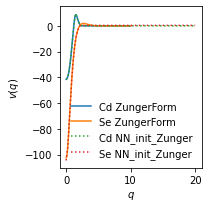

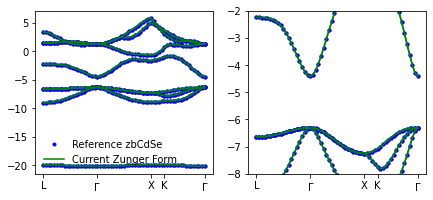

Using this code, can I reproduce the reference band structure to within 1e-11 eV? 
True


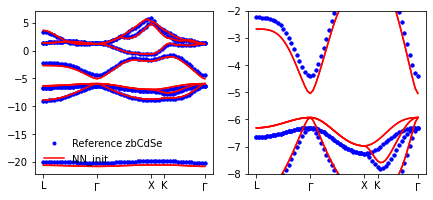

After fitting the NN to the latest function form, we can reproduce a satisfactory band structure. 


In [49]:
PPmodel.eval()
PPmodel.cpu()
plotqGrid = torch.linspace(0.0, 20.0, 3*NQGRID).view(-1, 1)
NN = PPmodel(plotqGrid)
plotPP([val_dataset.q, plotqGrid], [val_dataset.vq_Cd, NN[:, 0]], [val_dataset.vq_Se, NN[:, 1]], ["ZungerForm", f"NN_init_Zunger"], ["-", ":"], False);

basisStates = basis(maxKE, scale, unitCellVectors, gVectors, cellVolume)

current_Zunger_BandStruct = calcBandStruct(False, basisStates, nkpt, kpt_zbCdSe, nAtoms, cellVolume, nBands)
plotBandStruct([Eref_zbCdSe, current_Zunger_BandStruct], ["bo", "g-"], ["Reference zbCdSe", "Current Zunger Form"])
print("Using this code, can I reproduce the reference band structure to within 1e-11 eV? ")
print(torch.allclose(Eref_zbCdSe, current_Zunger_BandStruct, atol=1e-11))

NN_init_BandStruct = calcBandStruct(True, basisStates, nkpt, kpt_zbCdSe, nAtoms, cellVolume, nBands)
plotBandStruct([Eref_zbCdSe, NN_init_BandStruct], ["bo", "r-"], ["Reference zbCdSe", "NN_init"])
print("After fitting the NN to the latest function form, we can reproduce a satisfactory band structure. ")

Current Zunger form weighted MSE = 2.146739e-22 
Epoch [1/10], Loss: 146.2735


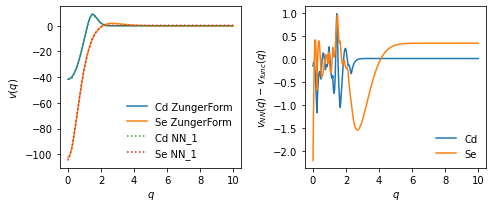

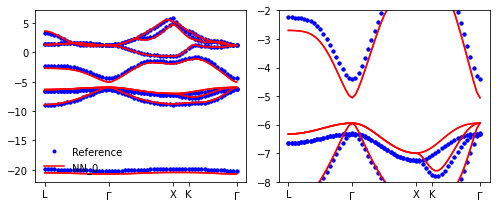

Epoch [2/10], Loss: 130.1644


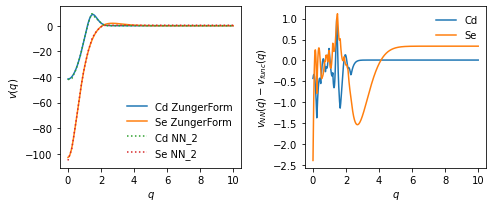

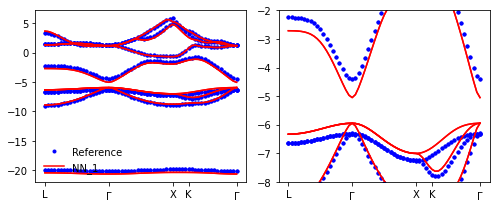

Epoch [3/10], Loss: 117.8796


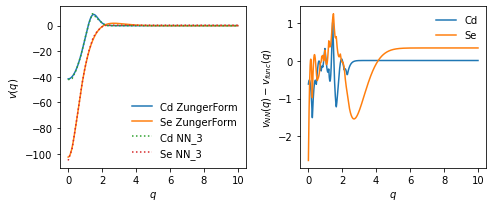

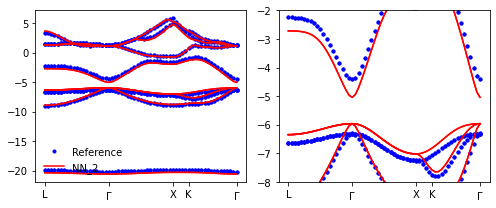

Epoch [4/10], Loss: 107.6377


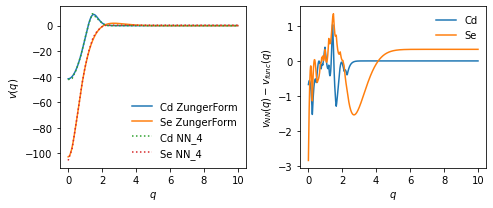

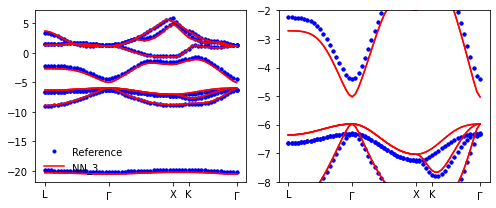

Epoch [5/10], Loss: 99.3851


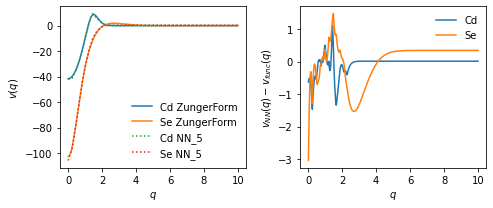

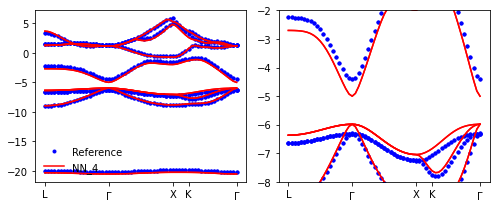

Epoch [6/10], Loss: 91.5940


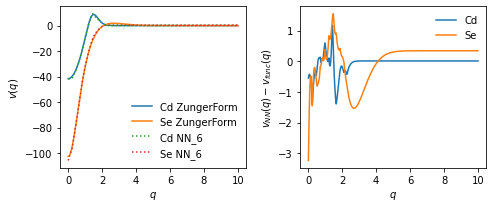

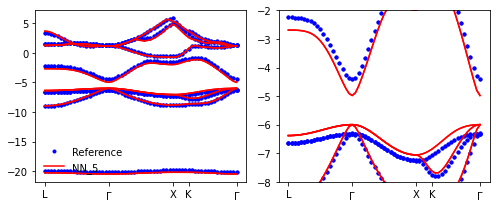

Epoch [7/10], Loss: 84.8049


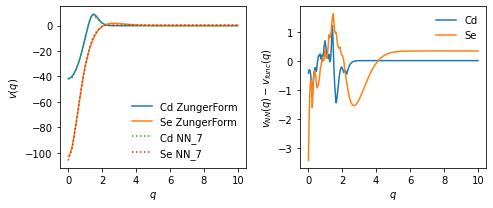

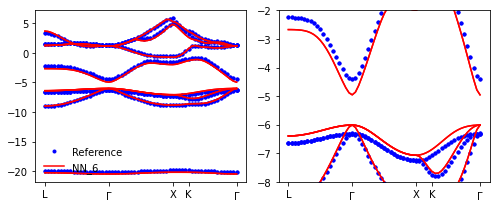

Epoch [8/10], Loss: 78.1729


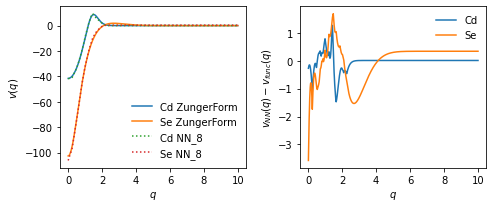

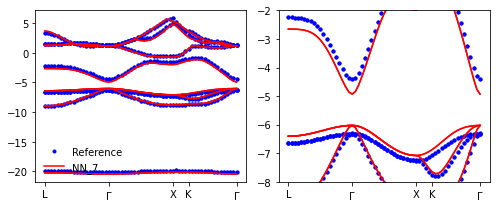

Epoch [9/10], Loss: 72.3497


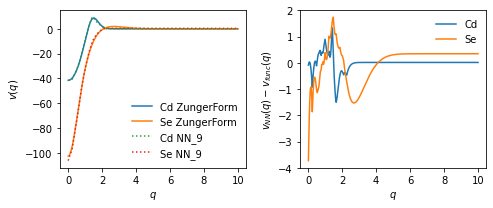

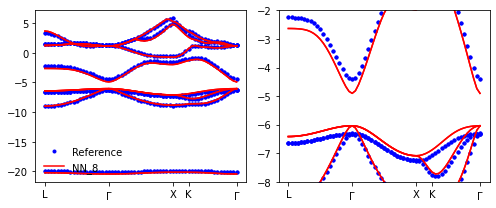

Epoch [10/10], Loss: 66.7057


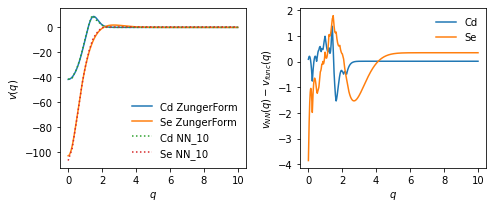

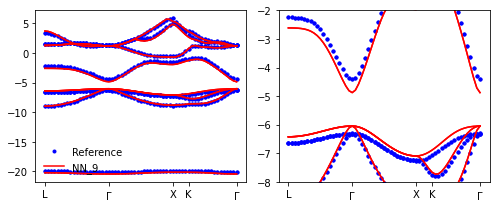

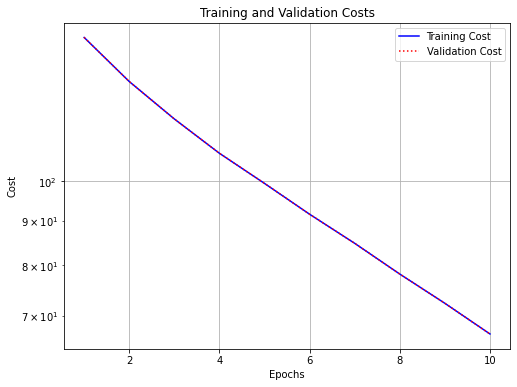

CPU training: elapsed time: 145.3258068561554 seconds


In [51]:
def weighted_mse_bandStruct(Ehat, E, bandWeights, kptWeights):
    if (len(bandWeights)!=nBands) or (len(kptWeights)!=nkpt): 
        raise ValueError("bandWeights or kptWeights lengths aren't correct. ")
        
    newBandWeights = bandWeights.view(1, -1).expand(nkpt, -1)
    newKptWeights = kptWeights.view(-1, 1).expand(-1, nBands)
    
    return torch.sum((Ehat-E)**2 * newBandWeights * newKptWeights)

def BandStruct_train(model, criterion, bandWeights, kptWeights, refBandStruct, optimizer, scheduler, scheduler_step, epochs, plot_every):
    LOSS=[]
    for epoch in range(epochs):
        # train
        model.train()
        NN_outputs = calcBandStruct(True, basisStates, nkpt, kpt_zbCdSe, nAtoms, cellVolume, nBands)
        loss = criterion(NN_outputs, refBandStruct, bandWeights, kptWeights)
        LOSS.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch > 0 and epoch % scheduler_step == 0:
            scheduler.step()
            
        # evaluation
        if (epoch + 1) % plot_every == 0:
            model.eval()
            NN_outputs = calcBandStruct(True, basisStates, nkpt, kpt_zbCdSe, nAtoms, cellVolume, nBands)
        
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
            plotPP([val_dataset.q, val_dataset.q], [val_dataset.vq_Cd, model(val_dataset.q.view(-1, 1))[:, 0]], [val_dataset.vq_Se, model(val_dataset.q.view(-1, 1))[:, 1]], ["ZungerForm", f"NN_{epoch+1}"], ["-", ":"], True);
            plotBandStruct([refBandStruct, NN_outputs], ["bo", "r-"], ["Reference", "NN_"+str(epoch)]);
    plot_training_validation_cost(LOSS, LOSS, True)
    return LOSS

PPmodel = nn_models.Net_relu_xavier([1, 20, 20, 20, 2])
PPmodel.load_state_dict(torch.load('PPmodel_initZunger.pth'))

optimizer = torch.optim.Adam(PPmodel.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.90)

criterion = weighted_mse_bandStruct
bandWeights=torch.ones(nBands)
bandWeights[4:8] = 2.0
kptWeights=torch.ones(nkpt)
kptWeights[[0, 20, 40]] = 2.0

print("Current Zunger form weighted MSE = %e " % weighted_mse_bandStruct(current_Zunger_BandStruct, Eref_zbCdSe, bandWeights, kptWeights))
####
# This might be wrong? Why so small? 
####

num_epochs = 10
plotEvery = 1
schedulerStep = 2

start_time = time.time()
LOSS = BandStruct_train(PPmodel, criterion, bandWeights, kptWeights, Eref_zbCdSe, optimizer, scheduler, schedulerStep, num_epochs, plotEvery)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"CPU training: elapsed time: {elapsed_time} seconds")

Epoch [5/50], Loss: 262.0571


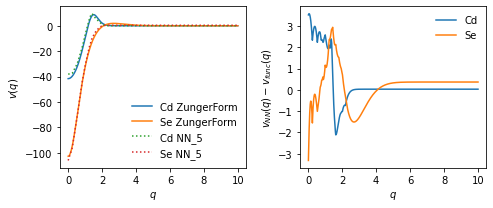

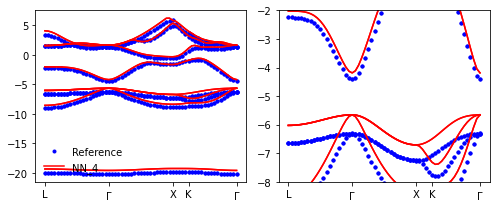

Epoch [10/50], Loss: 201.1054


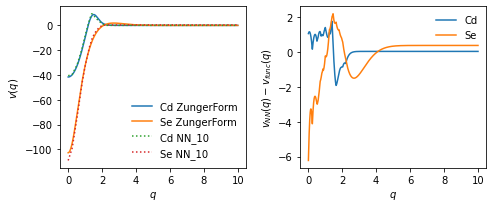

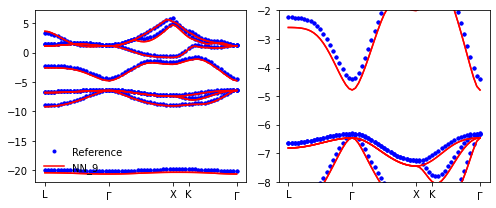

Epoch [15/50], Loss: 101.7302


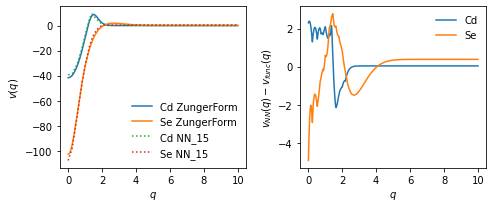

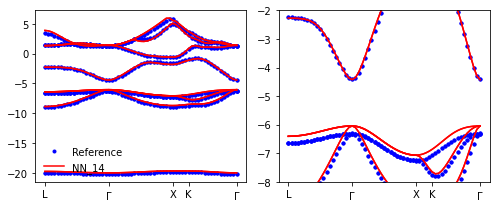

Epoch [20/50], Loss: 62.7837


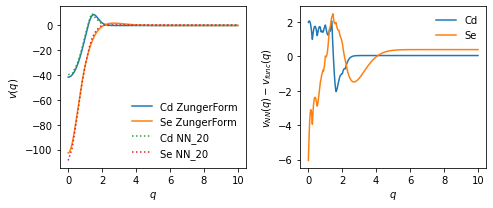

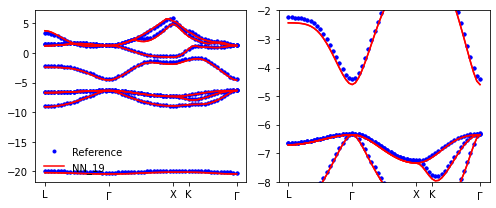

Epoch [25/50], Loss: 38.7385


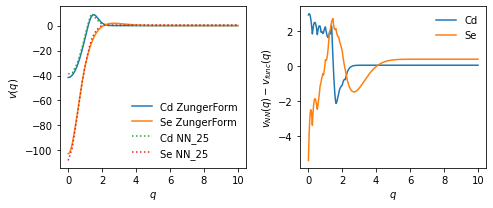

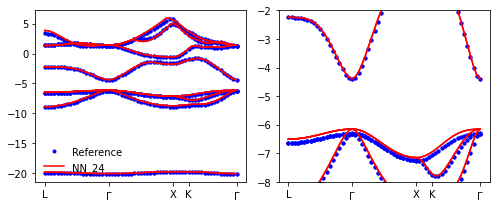

Epoch [30/50], Loss: 27.4864


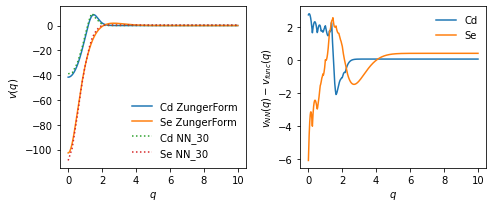

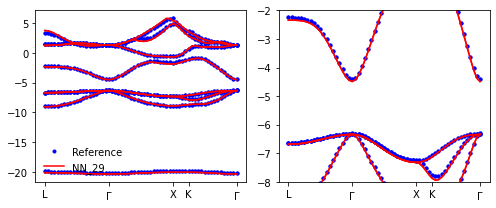

Epoch [35/50], Loss: 19.3409


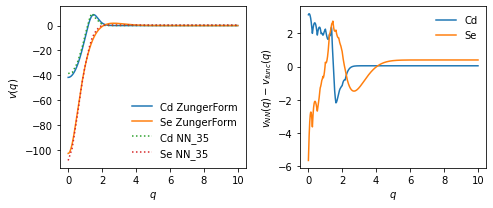

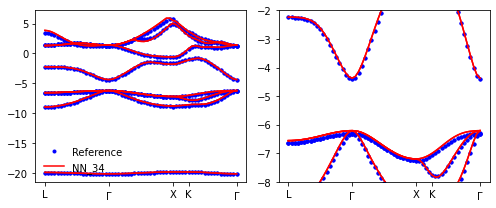

Epoch [40/50], Loss: 15.2653


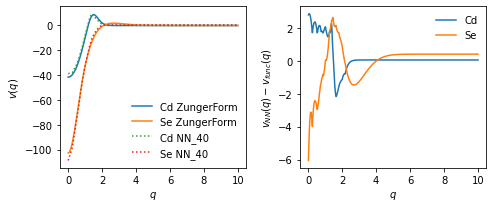

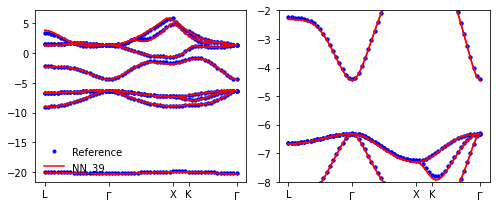

Epoch [45/50], Loss: 12.3868


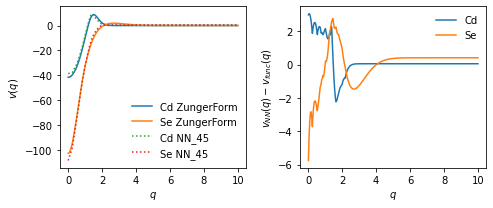

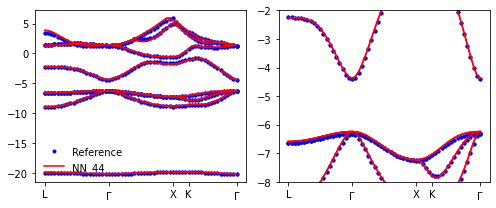

Epoch [50/50], Loss: 10.9700


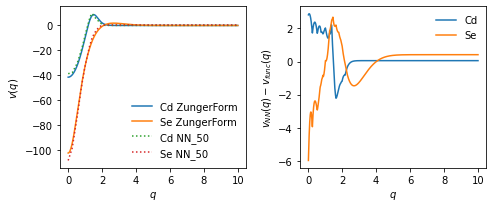

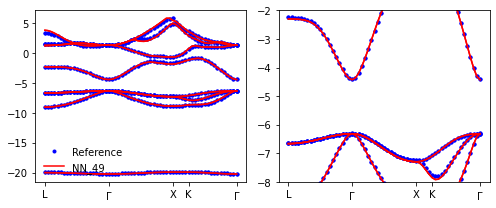

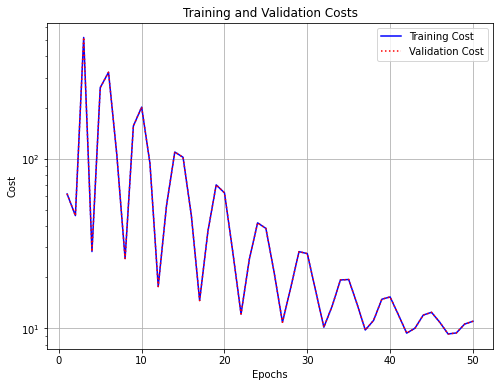

CPU training: elapsed time: 529.3673188686371 seconds


In [52]:
optimizer = torch.optim.Adam(PPmodel.parameters(), lr=0.005)
scheduler = ExponentialLR(optimizer, gamma=0.90)

num_epochs = 50
plotEvery = 5
schedulerStep = 10

start_time = time.time()
LOSS = BandStruct_train(PPmodel, criterion, bandWeights, kptWeights, Eref_zbCdSe, optimizer, scheduler, schedulerStep, num_epochs, plotEvery)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"CPU training: elapsed time: {elapsed_time} seconds")

Epoch [10/100], Loss: 13.2876


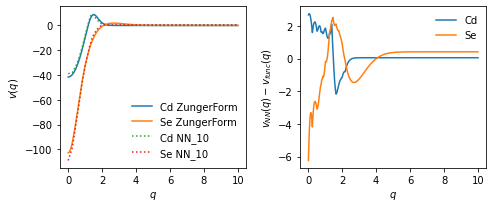

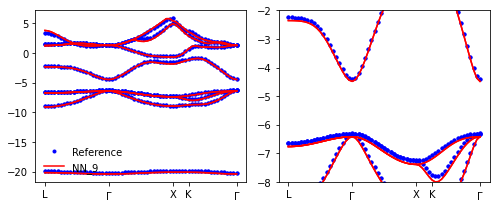

Epoch [20/100], Loss: 10.8843


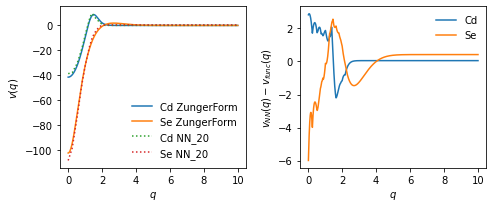

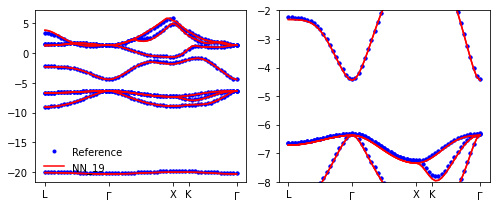

Epoch [30/100], Loss: 8.8996


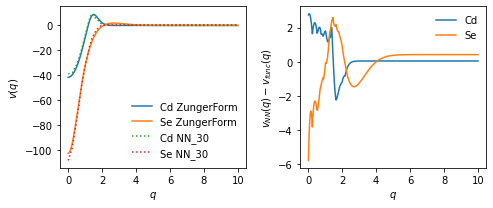

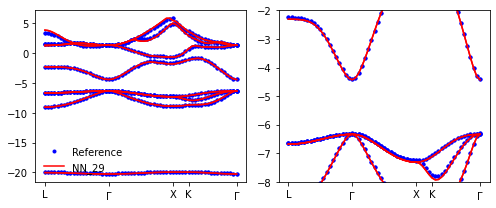

Epoch [40/100], Loss: 8.5294


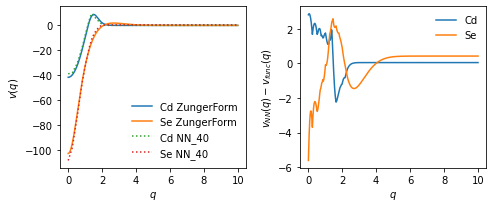

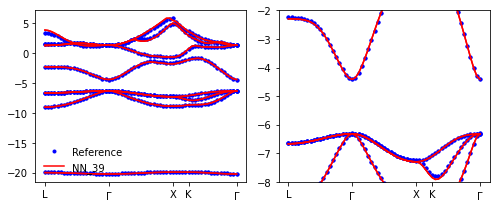

Epoch [50/100], Loss: 8.2354


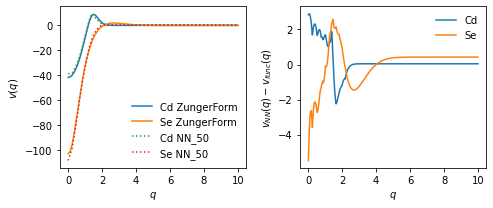

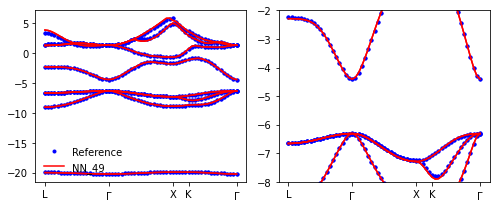

Epoch [60/100], Loss: 8.0197


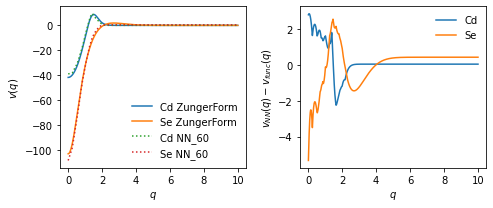

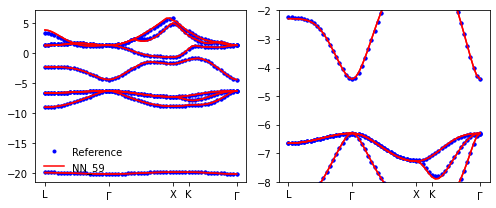

Epoch [70/100], Loss: 7.7945


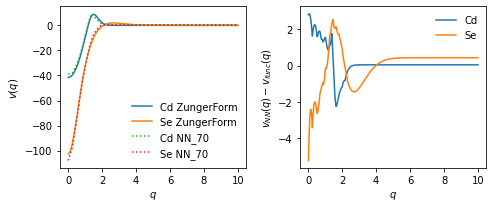

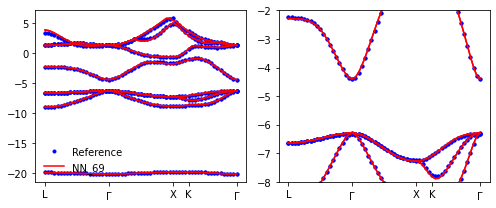

Epoch [80/100], Loss: 7.6237


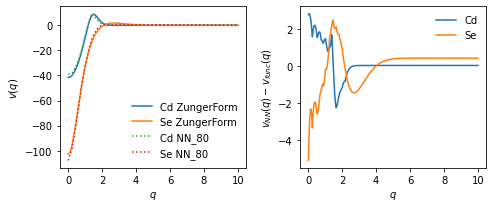

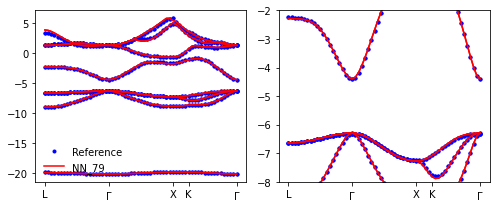

Epoch [90/100], Loss: 7.5026


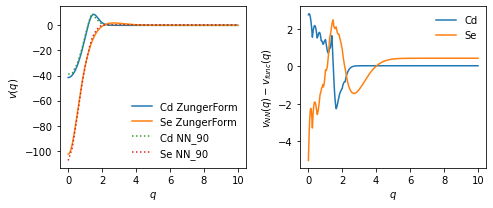

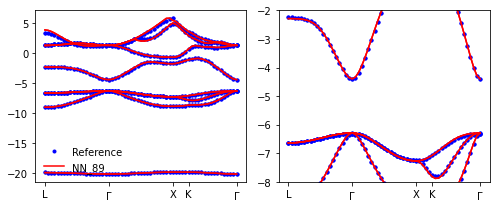

Epoch [100/100], Loss: 7.4029


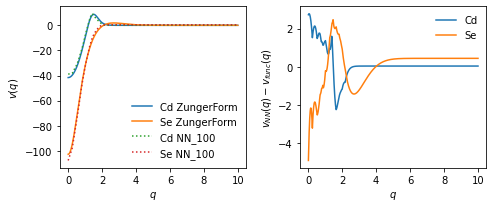

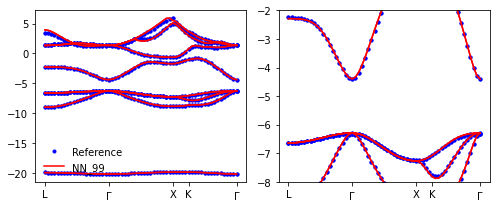

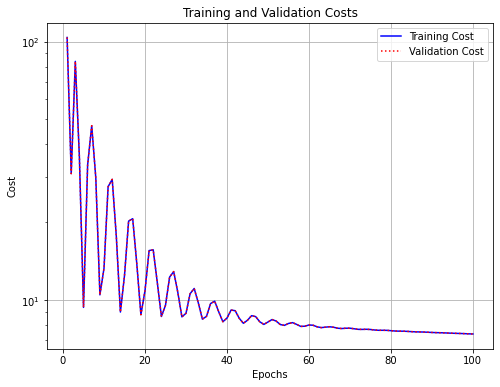

CPU training: elapsed time: 1043.96035695076 seconds


In [56]:
optimizer = torch.optim.Adam(PPmodel.parameters(), lr=0.002)
scheduler = ExponentialLR(optimizer, gamma=0.90)

num_epochs = 100
plotEvery = 10
schedulerStep = 20

start_time = time.time()
LOSS = BandStruct_train(PPmodel, criterion, bandWeights, kptWeights, Eref_zbCdSe, optimizer, scheduler, schedulerStep, num_epochs, plotEvery)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"CPU training: elapsed time: {elapsed_time} seconds")

In [ ]:
############ GPU #########

def calcHamiltonianMatrix_GPU(NN_boolean, basisStates, kVector, nAtoms, cellVolume, device):
    n = basisStates.shape[0]
    HMatrix = torch.zeros((n, n), dtype=torch.complex128)  # move to GPU

    # Kinetic energy
    for i in range(n): 
        HMatrix[i,i] += HBAR**2 / (2*MASS) * (torch.norm(basisStates[i] + kVector))**2
        
    # Local potential
    gDiff = torch.stack([basisStates] * (basisStates.shape[0]), dim=1) - basisStates.repeat(basisStates.shape[0], 1, 1)
    
    for k in range(nAtoms): 
        gDiffDotTau = torch.sum(gDiff * atomPos[k], axis=2)
        structFact = 1/cellVolume * (torch.cos(gDiffDotTau) + 1j*torch.sin(gDiffDotTau))

        thisAtomIndex = np.where(atomTypes[k]==PP_order)[0]
        if len(thisAtomIndex)!=1: 
            raise ValueError("Type of atoms in PP. ")
        thisAtomIndex = thisAtomIndex[0]
        
        if NN_boolean: 
            atomFF = PPmodel(torch.norm(gDiff, dim=2).view(-1, 1))
            atomFF = atomFF[:, thisAtomIndex].view(n, n)
        else: 
            atomFF = pot_func(torch.norm(gDiff, dim=2), totalParams[thisAtomIndex])
        
        HMatrix += atomFF * structFact
    return HMatrix

def calcBandStruct_GPU(NN_boolean, basisStates, nkpt, kpts_coord, nAtoms, cellVolume, nBands, device): 
    bandStruct = torch.zeros((nkpt, nBands))
    for kpt_index in range(nkpt): 
        HamiltonianMatrixAtKpt = calcHamiltonianMatrix_GPU(NN_boolean, basisStates, kpts_coord[kpt_index], nAtoms, cellVolume, device)

        # diagonalize the hamiltonian
        energies = torch.linalg.eigvalsh(HamiltonianMatrixAtKpt)
        
        energiesEV = energies * AUTOEV
        # 2-fold degeneracy due to spin
        final_energies = energiesEV.repeat_interleave(2)[:nBands]
    
        bandStruct[kpt_index] = final_energies

    return bandStruct

def BandStruct_train_GPU(model, device, criterion, bandWeights, kptWeights, refBandStruct, optimizer, scheduler, scheduler_step, epochs, plot_every):
    LOSS=[]
    for epoch in range(epochs):
        # train
        model.train()
        NN_outputs = calcBandStruct(True, basisStates, nkpt, kpt_zbCdSe, nAtoms, cellVolume, nBands)  # move to GPU
        loss = criterion(NN_outputs, refBandStruct, bandWeights, kptWeights)
        LOSS.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch > 0 and epoch % scheduler_step == 0:
            scheduler.step()
            
        # evaluation
        if (epoch + 1) % plot_every == 0:
            model.eval()
            NN_outputs = calcBandStruct(True, basisStates, nkpt, kpt_zbCdSe, nAtoms, cellVolume, nBands)     # move to GPU
        
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
            plotPP([val_dataset.q, val_dataset.q], [val_dataset.vq_Cd, model(val_dataset.q.view(-1, 1))[:, 0]], [val_dataset.vq_Se, model(val_dataset.q.view(-1, 1))[:, 1]], ["ZungerForm", f"NN_{epoch+1}"], ["-", ":"], True);
            plotBandStruct([refBandStruct, NN_outputs], ["bo", "r-"], ["Reference", "NN_"+str(epoch)]);
    plot_training_validation_cost(LOSS, LOSS, True)
    return LOSS

PPmodel = nn_models.Net_relu_xavier([1, 20, 20, 20, 2])
PPmodel.load_state_dict(torch.load('PPmodel_initZunger.pth'))

optimizer = torch.optim.Adam(PPmodel.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.90)

criterion = weighted_mse_bandStruct
bandWeights=torch.ones(nBands)
bandWeights[4:8] = 2.0
kptWeights=torch.ones(nkpt)
kptWeights[[0, 20, 40]] = 2.0

num_epochs = 1
plotEvery = 1
schedulerStep = 2

start_time = time.time()
LOSS = BandStruct_train_GPU(PPmodel, device, criterion, bandWeights, kptWeights, Eref_zbCdSe, optimizer, scheduler, schedulerStep, num_epochs, plotEvery)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"CPU training: elapsed time: {elapsed_time} seconds")